In [16]:
"""Generalized code.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1a8-ixAnXjvv7p4Ap58P9FANN01IhQK9T
"""

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  
  
  

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, CuDNNGRU, LSTM, CuDNNLSTM, Bidirectional
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive/Colab Notebooks

print(os.getcwd()) 
print(os.listdir(os.getcwd()))


/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks
['Untitled0.ipynb', '.ipynb_checkpoints', 'hourly_irish_weather.csv']


In [8]:
df = pd.read_csv('hourly_irish_weather.csv')
df.head()
df.dtypes


df['temp'] = pd.to_numeric(df['temp'])
df['dewpt'] = pd.to_numeric(df['dewpt'])
df['vappr'] = pd.to_numeric(df['vappr'])
df['dewpt'] = pd.to_numeric(df['dewpt'])

df.dtypes

Unnamed: 0      int64
date           object
station        object
county         object
longitude     float64
latitude      float64
rain          float64
temp          float64
wetb          float64
dewpt         float64
vappr         float64
rhum          float64
msl           float64
wdsp          float64
wddir         float64
ww            float64
w             float64
sun           float64
vis           float64
clht          float64
clamt         float64
dtype: object

In [9]:
df_cork = df[df.county == 'Cork']

# Displaying sample data first 5 rows
df_cork.head()

,Unnamed: 0,date,station,county,longitude,latitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.1,8.7,8.3,10.9,95.0,1036.3,13.0,190.0,10.0,22.0,0.0,10000.0,22.0,7.0
1,1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,11.0,96.0,1036.2,13.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
2,2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,8.9,8.5,8.1,10.8,95.0,1036.0,12.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
3,3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.7,8.4,11.0,96.0,1035.9,11.0,190.0,10.0,22.0,0.0,8000.0,4.0,8.0
4,4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,0.0,9.0,8.6,8.2,10.8,95.0,1035.8,10.0,190.0,10.0,22.0,0.0,10000.0,14.0,8.0


In [10]:
df_cork.shape
df_cork.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735357 entries, 0 to 735356
Data columns (total 21 columns):
Unnamed: 0    735357 non-null int64
date          735357 non-null object
station       735357 non-null object
county        735357 non-null object
longitude     735357 non-null float64
latitude      735357 non-null float64
rain          732590 non-null float64
temp          714410 non-null float64
wetb          706510 non-null float64
dewpt         706557 non-null float64
vappr         683446 non-null float64
rhum          683476 non-null float64
msl           700182 non-null float64
wdsp          732910 non-null float64
wddir         731469 non-null float64
ww            254208 non-null float64
w             254208 non-null float64
sun           254208 non-null float64
vis           254192 non-null float64
clht          254208 non-null float64
clamt         254208 non-null float64
dtypes: float64(17), int64(1), object(3)
memory usage: 123.4+ MB


In [11]:
df_cork = df_cork[['date','station','county','longitude','latitude','temp','wetb','dewpt','vappr']].copy()
df_cork.head()

,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr
0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,9.1,8.7,8.3,10.9
1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0
2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,8.9,8.5,8.1,10.8
3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0
4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.6,8.2,10.8


In [0]:
   # replace field that's entirely space (or empty) with NaN
    df_cork = df_cork.replace(r'^\s*$', np.nan, regex=True)

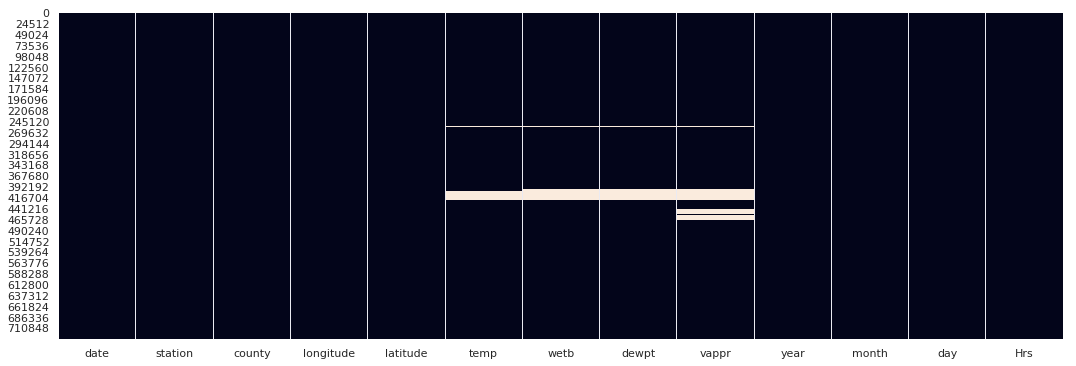

In [59]:
df_cork.isnull().values.any()

sns.heatmap(df_cork.isnull(), cbar=False)

In [13]:


df_cork['date'] = df_cork['date'].astype('str')


df_cork[['year','month','day']] = df_cork.date.str.split("-",expand=True,)
df_cork[['day','Hrs']] = df_cork.day.str.split(" ",expand=True,)
df_cork.head()


,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr,year,month,day,Hrs
0,1989-01-01 00:00:00,Cork_Airport,Cork,-8.485,51.842,9.1,8.7,8.3,10.9,1989,01,01,00:00:00
1,1989-01-01 01:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0,1989,01,01,01:00:00
2,1989-01-01 02:00:00,Cork_Airport,Cork,-8.485,51.842,8.9,8.5,8.1,10.8,1989,01,01,02:00:00
3,1989-01-01 03:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.7,8.4,11.0,1989,01,01,03:00:00
4,1989-01-01 04:00:00,Cork_Airport,Cork,-8.485,51.842,9.0,8.6,8.2,10.8,1989,01,01,04:00:00


In [14]:
df_cork_null = df_cork[df_cork.isna().any(axis=1)]
df_cork_null.head()

,date,station,county,longitude,latitude,temp,wetb,dewpt,vappr,year,month,day,Hrs
158225,2007-01-19 17:00:00,Cork_Airport,Cork,-8.485,51.842,11.2,11.6,11.1,NaN,2007,01,19,17:00:00
181068,2009-08-28 12:00:00,Cork_Airport,Cork,-8.485,51.842,15.0,NaN,8.8,11.3,2009,08,28,12:00:00
181069,2009-08-28 13:00:00,Cork_Airport,Cork,-8.485,51.842,13.4,NaN,9.9,12.2,2009,08,28,13:00:00
181070,2009-08-28 14:00:00,Cork_Airport,Cork,-8.485,51.842,14.8,NaN,7.8,10.6,2009,08,28,14:00:00
181071,2009-08-28 15:00:00,Cork_Airport,Cork,-8.485,51.842,14.0,NaN,8.4,11.1,2009,08,28,15:00:00


In [15]:
df_cork_null.year.value_counts()

1994    8736
2000    8570
1993    8015
1995    7727
1999    7606
1998    5552
2001    1485
1996    1467
2003    1139
2004     708
2005     188
2006     172
2008     163
2007      97
1997      89
2002      62
2017      57
2010      29
2011      28
2009      22
2012      21
2014      11
2015      10
2013       4
Name: year, dtype: int64

In [16]:
df_cork_notnull = df_cork.dropna(axis = 0, how ='any')

# Displaying dataframe count with and without null values 

print("Old data frame length:", len(df_cork), "\nNew data frame length:",  
       len(df_cork_notnull), "\nNumber of rows with at least 1 NA value: ", 
       (len(df_cork_null)-len(df_cork_notnull))) 

Old data frame length: 735357 
New data frame length: 683399 
Number of rows with at least 1 NA value:  -631441


In [62]:
if len(df_cork_notnull[df_cork_notnull.duplicated()]) > 0:
        print("\n***Number of duplicated entries: ", len(df_cork_notnull[df_cork_notnull.duplicated()]))
        display(df_cork_notnull[df_cork_notnull.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
        print("\nNo duplicated entries found")


No duplicated entries found


In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 6)})
rs = np.random.RandomState(0)
corr = df_cork_notnull.corr()
corr.style.background_gradient(cmap='coolwarm')

,longitude,latitude,temp,wetb,dewpt,vappr
longitude,1,0.79782,-0.0724416,-0.0807874,-0.0777636,-0.0766135
latitude,0.79782,1,-0.0743315,-0.0869614,-0.0866764,-0.0816145
temp,-0.0724416,-0.0743315,1,0.971743,0.87343,0.858213
wetb,-0.0807874,-0.0869614,0.971743,1,0.959528,0.94451
dewpt,-0.0777636,-0.0866764,0.87343,0.959528,1,0.975122
vappr,-0.0766135,-0.0816145,0.858213,0.94451,0.975122,1


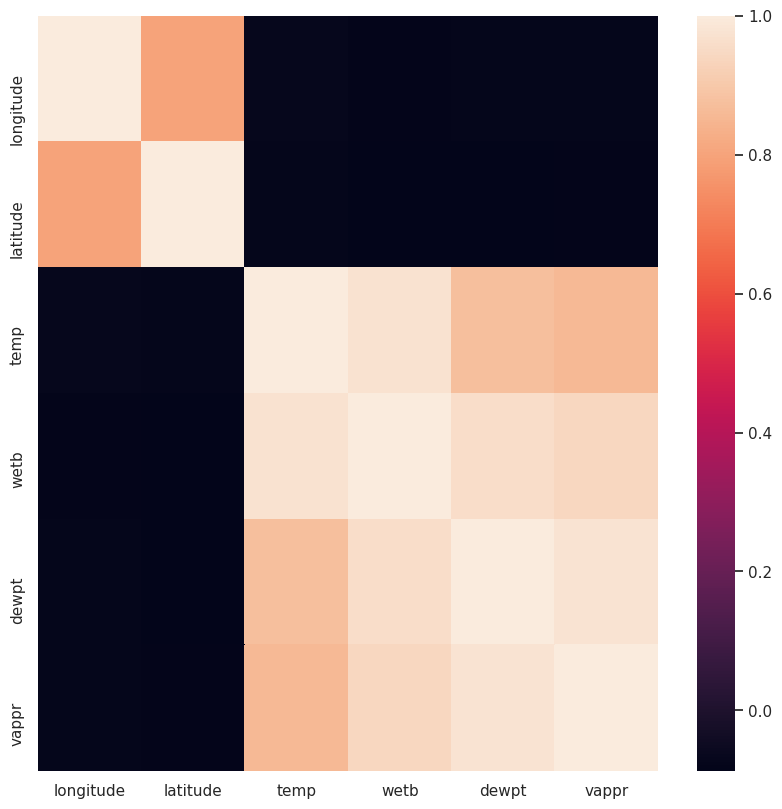

In [19]:
# Corelation plot of dataframe 

plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(df_cork_notnull.corr())

***Basic Statistics ***

In [0]:
df = df_cork_notnull.copy()
df= df.drop(['date','station', 'county', 'longitude','latitude','year','month','Hrs'], axis=1)


In [0]:
def numeric_eda(df, hue=None):
    """Given dataframe, generate EDA of numeric data"""
    print("\nTo check: \nDistribution of numeric data")
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()
    
    if len(df.select_dtypes(include='category').columns) > 0:
        for col_num in df.select_dtypes(include=np.number).columns:
            for col in df.select_dtypes(include='category').columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=df, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()
    
 



To check: 
Distribution of numeric data


,count,mean,std,min,25%,50%,75%,max
temp,683399.0,10.302814,4.461044,-12.3,7.4,10.5,13.6,28.3
wetb,683399.0,9.098385,4.179462,-49.0,6.2,9.4,12.2,21.8
dewpt,683399.0,7.764638,4.504539,-92.4,4.5,8.2,11.1,20.4
vappr,683399.0,10.970749,3.235288,0.0,8.4,10.9,13.2,23.9


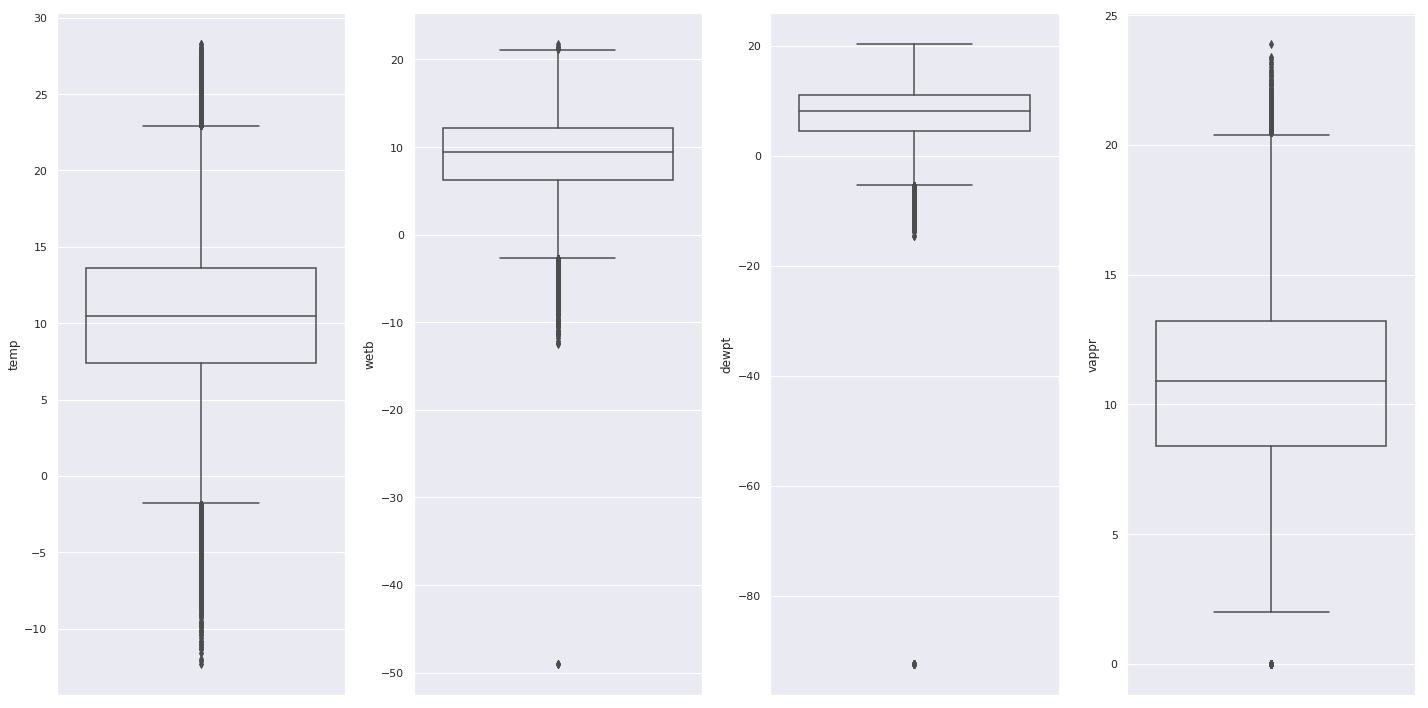

In [53]:
 numeric_eda(df, hue='day')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


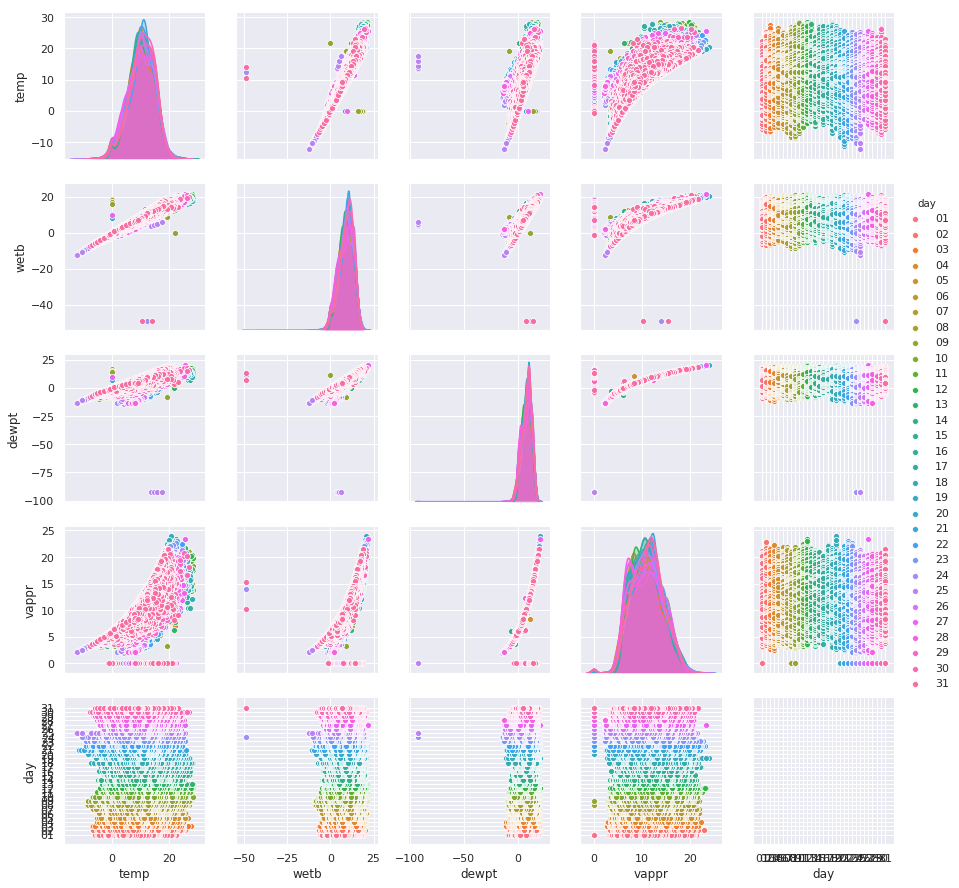

In [57]:
import seaborn as sns


sns.pairplot(df, hue="day")

In [74]:
df_cork_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683399 entries, 0 to 735356
Data columns (total 13 columns):
date         683399 non-null object
station      683399 non-null object
county       683399 non-null object
longitude    683399 non-null float64
latitude     683399 non-null float64
temp         683399 non-null float64
wetb         683399 non-null float64
dewpt        683399 non-null float64
vappr        683399 non-null float64
year         683399 non-null object
month        683399 non-null object
day          683399 non-null object
Hrs          683399 non-null object
dtypes: float64(6), object(7)
memory usage: 73.0+ MB


In [0]:
df_cork_notnull['date'] =  pd.to_datetime(df_cork_notnull['date'], format='%Y/%m/%d %H:%M')
df1= df_cork_notnull.drop(['station', 'county', 'longitude','latitude','year','month','Hrs','day'], axis=1)



In [0]:
def time_series_plot(df):
    
    """Given dataframe, generate times series plot of numeric data by daily, monthly and yearly frequency"""
    
    print("\nTo check time series of numeric data  by daily, monthly and yearly frequency")
    
    if len(df.select_dtypes(include='datetime64').columns)>0:
        for col in df.select_dtypes(include='datetime64').columns:
            for p in ['H', 'D', 'M', 'Y']:
                
                if p=='H':
                    print("Plotting Hourly data")
                elif p=='D':
                    print("Plotting daily data")
                elif p=='M':
                    print("Plotting monthly data")
                else:
                    print("Plotting yearly data")
                    
                for col_num in df.select_dtypes(include=np.number).columns:
                    __ = df.copy()
                    __ = __.set_index(col)
                    __T = __.resample(p).mean()
                    ax = __T[[col_num]].plot(color='m')
                    ax.set_ylim()
                    ax.get_yaxis().set_major_formatter(
                    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                    plt.show()


To check time series of numeric data  by daily, monthly and yearly frequency
Plotting Hourly data


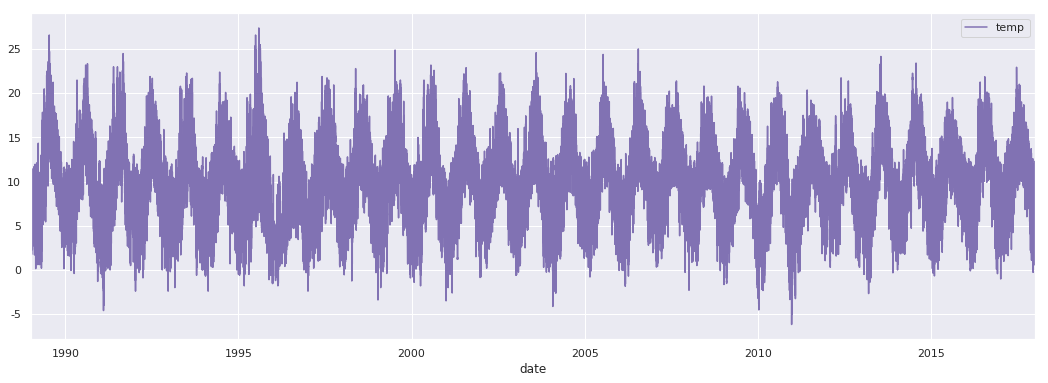

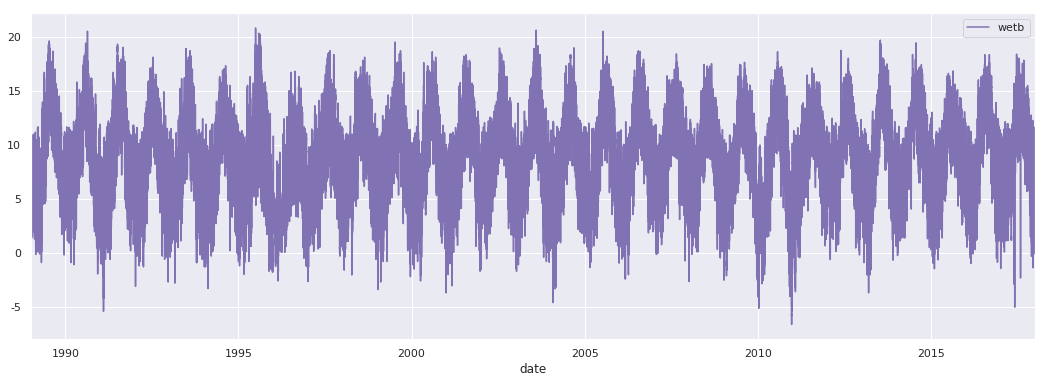

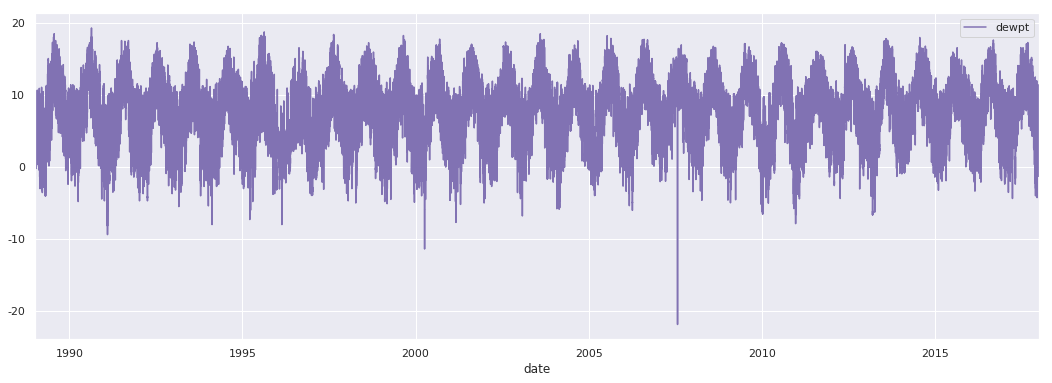

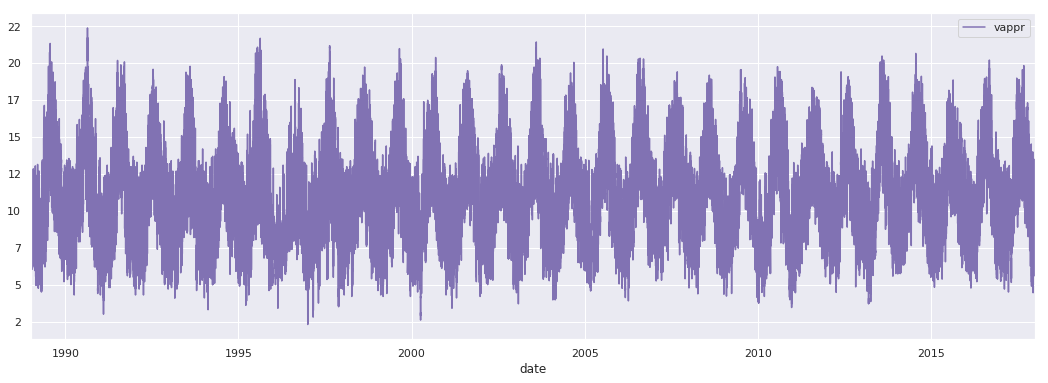

Plotting daily data


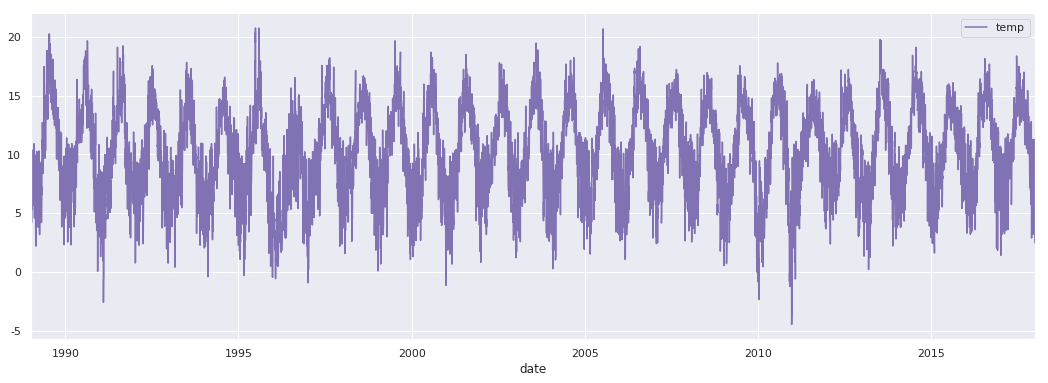

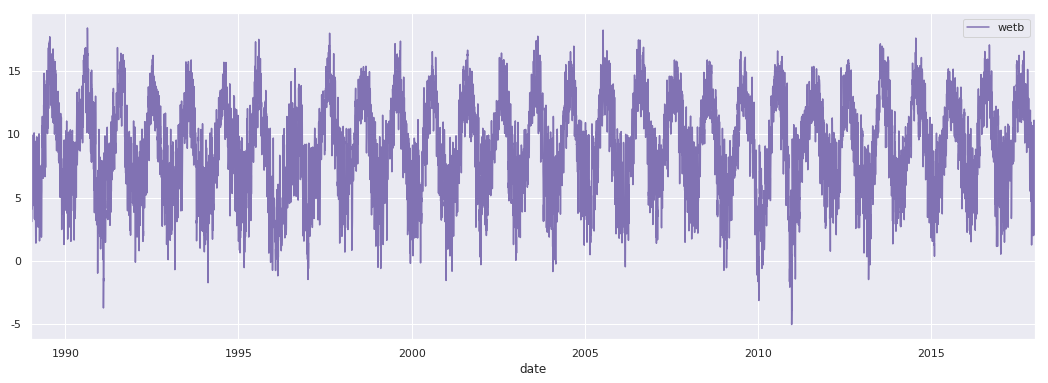

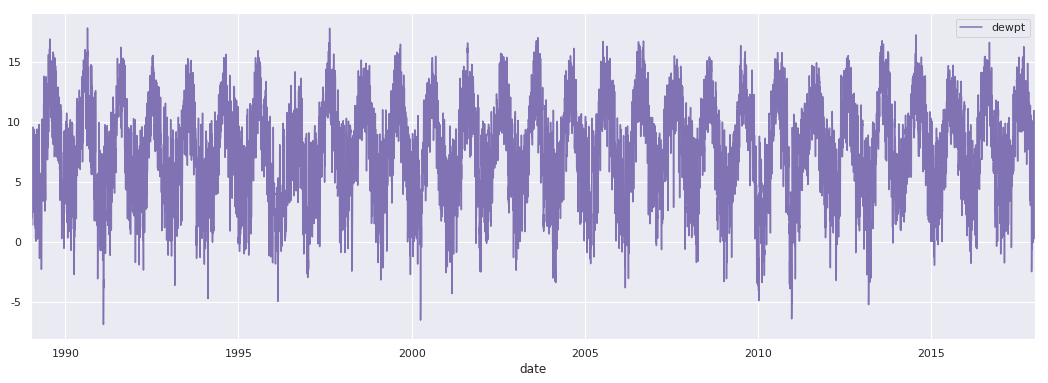

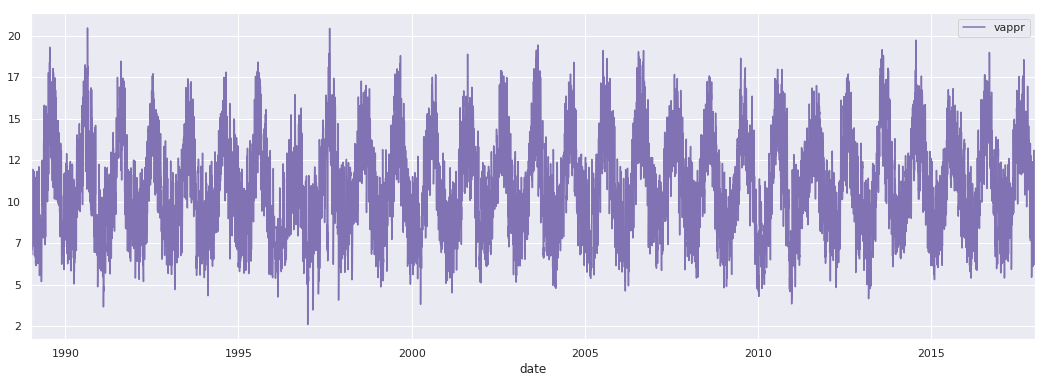

Plotting monthly data


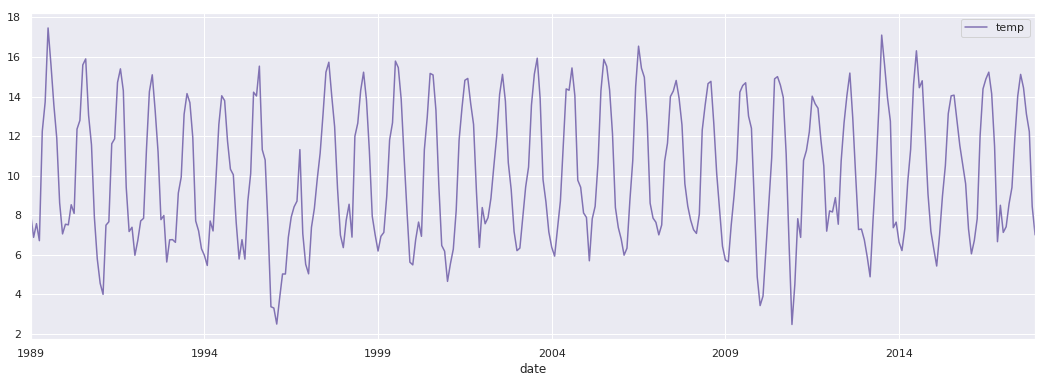

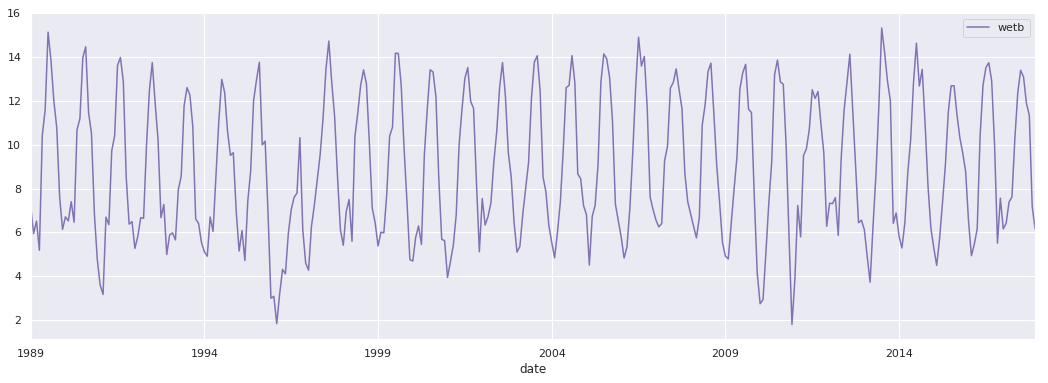

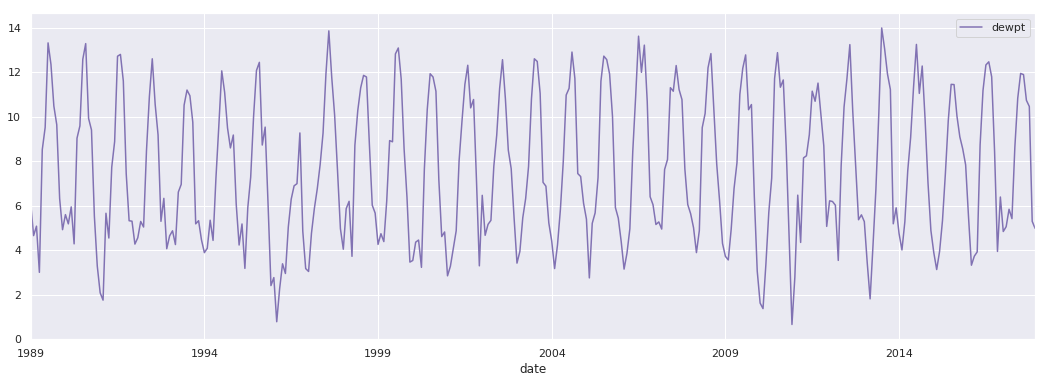

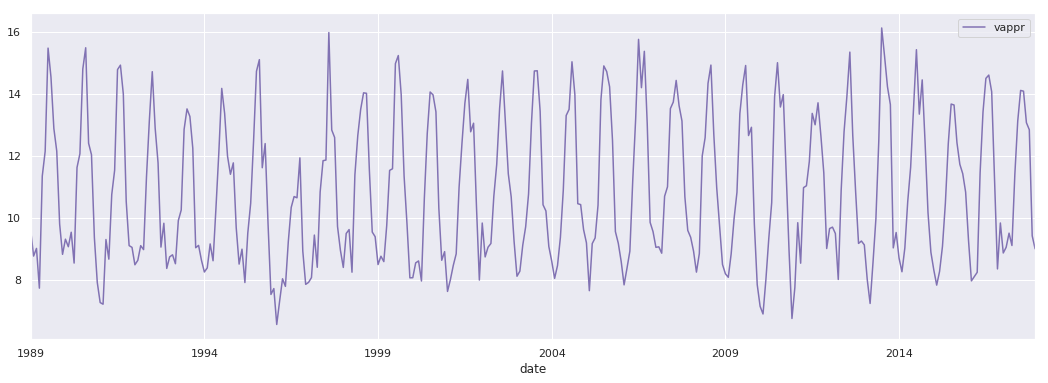

Plotting yearly data


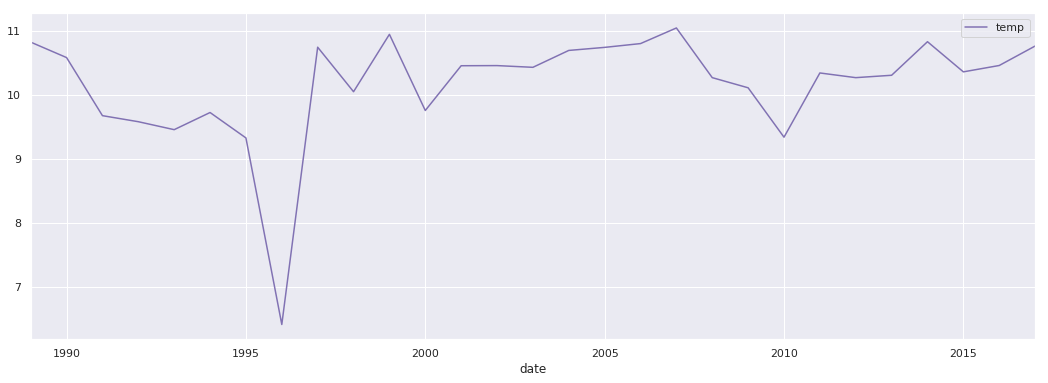

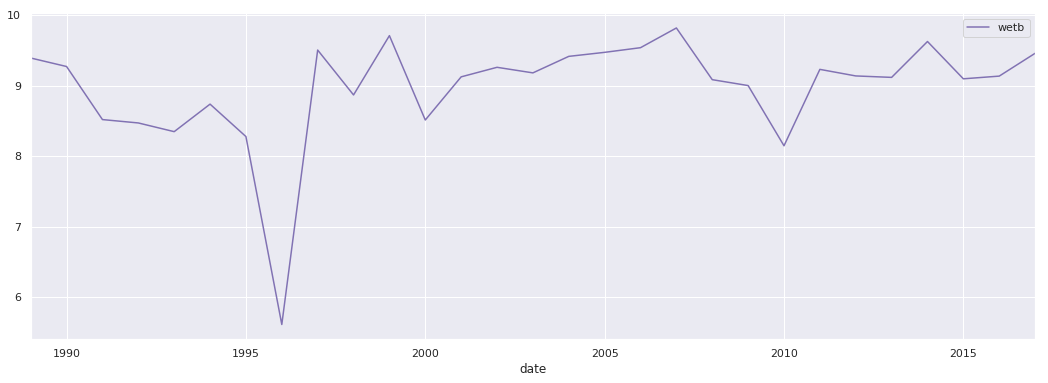

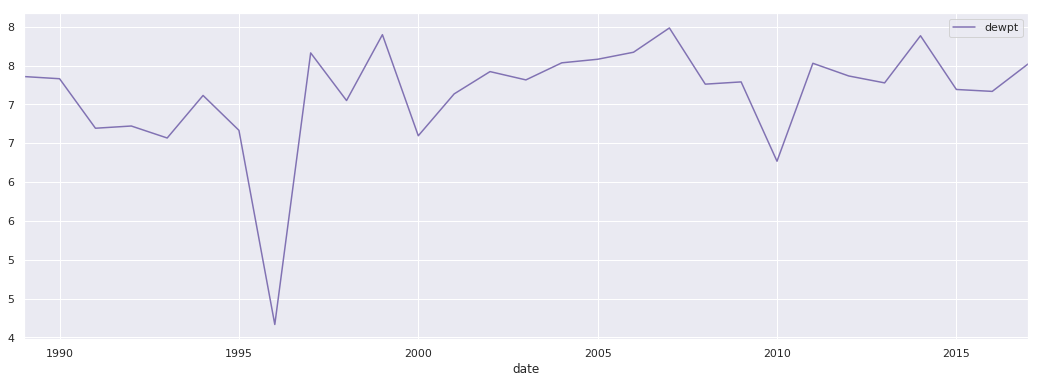

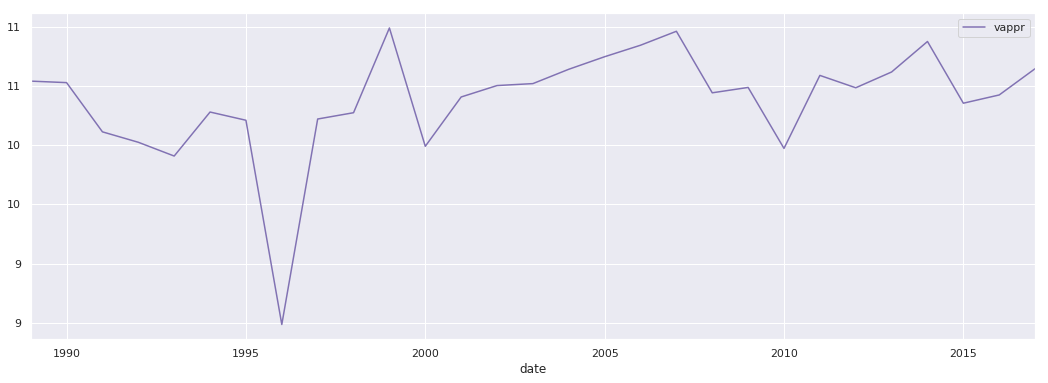

In [126]:
time_series_plot(df1)